# Модуль 2. Качество и чистка данных
---
## Федоров Георгий

In [1]:
import praw
import os
import random
from PIL import Image
import re
import json
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import polars as pl
from tqdm import tqdm
import seaborn as sns

from IPython.display import clear_output

## **Часть 1: «Следствие ведёт детектив»**

- [ ]  Возьмите датасет из задания №1 [Модуль 1. **Введение в сбор данных**](https://www.notion.so/1-341985de290d4c1280ba3856ac98925f?pvs=21)
- [ ]  Проанализируйте пропуски: определите их процент и расположение (случайны ли пропуски или есть закономерность?)
- [ ]  Сформулируйте гипотезу о возможных причинах появления пропусков.
- [ ]  Проанализируйте датасет на выбросы удобным вам методом.

In [3]:
df = pd.read_csv('posts_cleaner_2.csv').drop(columns='Unnamed: 0')
df

,link_flair_text,url,link_flair_css_class,id,created_utc,title,author,selftext,domain,num_comments,ups,score,is_reddit_media_domain,total_awards_received,upvote_ratio,src
0,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9h62,1.340082e+09,Can someone edit this pic for me?,UnknownReddit007,This is probably a stupid thing to ask as it s...,self.PhotoshopRequest,0,1.0,1,NaN,NaN,NaN,archive
1,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,v9fi1,1.340080e+09,Can someone edit this picture for me?,[deleted],This is probably a stupid thing to ask as it s...,self.PhotoshopRequest,0,1.0,1,NaN,NaN,NaN,archive
2,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,x43s2,1.343189e+09,Need Subreddit Mascot,nismomonkey,Looking for a Reddit Alien for our new Subredd...,self.PhotoshopRequest,0,1.0,1,NaN,NaN,NaN,archive
3,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10by6r,1.348378e+09,Can you create a logo for my brand?,Aerimae,NaN,self.PhotoshopRequest,0,1.0,1,NaN,NaN,NaN,archive
4,NaN,http://www.reddit.com/r/PhotoshopRequest/comme...,NaN,10ev4t,1.348521e+09,I need to make a joke Birthday present for a f...,[deleted],Id like to put this funny-looking picture of m...,self.PhotoshopRequest,0,1.0,1,NaN,NaN,NaN,archive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541475,Free :snoo:,https://www.reddit.com/gallery/1jynipv,free,1jynipv,1.744595e+09,Car colors,Cheese1324,Could someone please make the red car the same...,reddit.com,4,1.0,1,0.0,0.0,1.0,api
541476,Paid :redditgold:,https://i.redd.it/zhr3j8gl8pue1.jpeg,paid,1jymrja,1.744592e+09,Help making some changes to a t-shirt design,Passessor,I’m looking to do a few things to this design:...,i.redd.it,19,1.0,1,1.0,0.0,1.0,api
541477,Paid :redditgold:,https://www.reddit.com/gallery/1jymegb,paid,1jymegb,1.744591e+09,Can anyone complete and clean up this old and ...,throwrachacha100,It’s gotten really damaged over time and it’s ...,reddit.com,15,1.0,1,0.0,0.0,1.0,api
541478,Paid :redditgold:,https://i.redd.it/h4cnoiv53pue1.jpeg,NaN,1jym7l3,1.744591e+09,Can anyone edit out the guy on the right? Will...,spectralcanvas,I never get the chance to dress up nice and go...,i.redd.it,13,1.0,1,1.0,0.0,1.0,api


In [4]:
# посмотрим число пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541480 entries, 0 to 541479
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   link_flair_text         376389 non-null  object 
 1   url                     527514 non-null  object 
 2   link_flair_css_class    324378 non-null  object 
 3   id                      541480 non-null  object 
 4   created_utc             541480 non-null  float64
 5   title                   541480 non-null  object 
 6   author                  541470 non-null  object 
 7   selftext                240880 non-null  object 
 8   domain                  527489 non-null  object 
 9   num_comments            541480 non-null  int64  
 10  ups                     287251 non-null  float64
 11  score                   541480 non-null  int64  
 12  is_reddit_media_domain  413327 non-null  float64
 13  total_awards_received   345125 non-null  float64
 14  upvote_ratio        

Как видим, во многих признаках есть пропуски.
> Однако это ещё не всё. В нашем датасете пропусками могут быть не только NaN, None и ' ' \
> Бывают ещё и заглушки, вроде `[deleted]` \
> Важно обращать внимание и на них

### link_flair_text, link_flair_css_class
---
напоминаю, это тип поста (платный/бесплатный)\
нам это важно на этапе парсинга картинок (будет потом):
- на платные запросы картинки-ответы в комментариях только с ватермарками -> не годятся как обучающий датасет, но тексты-запросы взять можно
- на бесплатные запросы картинки почти всегда без ваттермарок

In [36]:
df['link_flair_text'].isna().value_counts()

link_flair_text
False    376389
True     165091
Name: count, dtype: int64

<Figure size 1200x1000 with 0 Axes>

In [39]:
df['link_flair_css_class'].isna().value_counts()

link_flair_css_class
False    324378
True     217102
Name: count, dtype: int64

Пропусков очень много.

Хочется посмотреть на их частотность на протяжении датасета. \
Просто нарисовать не выйдет - слишком много данных, будет неразбериха. \
Поэтому напишем функцию для усреднения скользящим средним

In [94]:
def nan_roll_avg(frame, col, window=1000):
    
    nan_mask = frame[col].isna().astype(int)
    rolling_nan_rate = nan_mask.rolling(window).mean()
    
    plt.figure(figsize=(12, 4))
    plt.plot(rolling_nan_rate, color='red')
    plt.title(f"Rolling NaN Rate in '{col}' Column (window={window})")
    plt.xlabel("Row Index")
    plt.ylabel("NaN Rate")
    plt.grid()
    plt.tight_layout()
    plt.show()

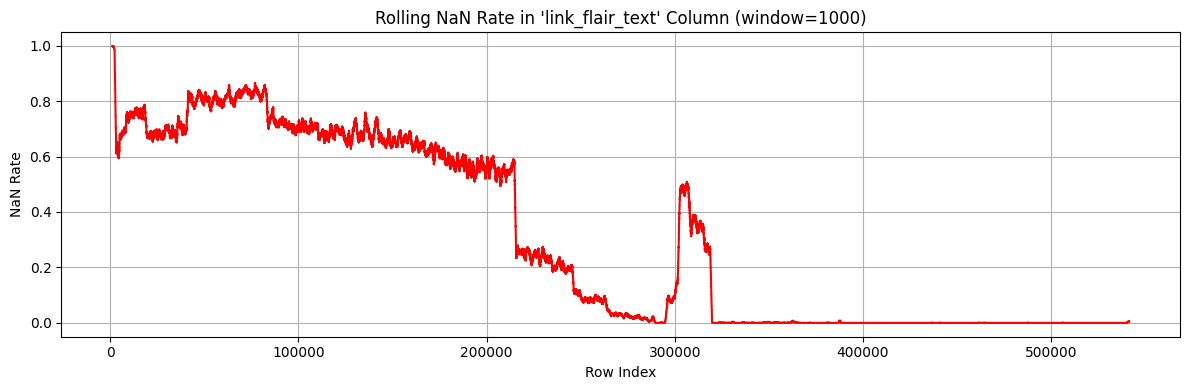

In [52]:
nan_roll_avg(df, 'link_flair_text')

Видим основную причину пропусков:
> Давным-давно в сабреддите не было строгих правил и системы меток для постов \
> но со временем они появились, и NaN-ы почти исчезли

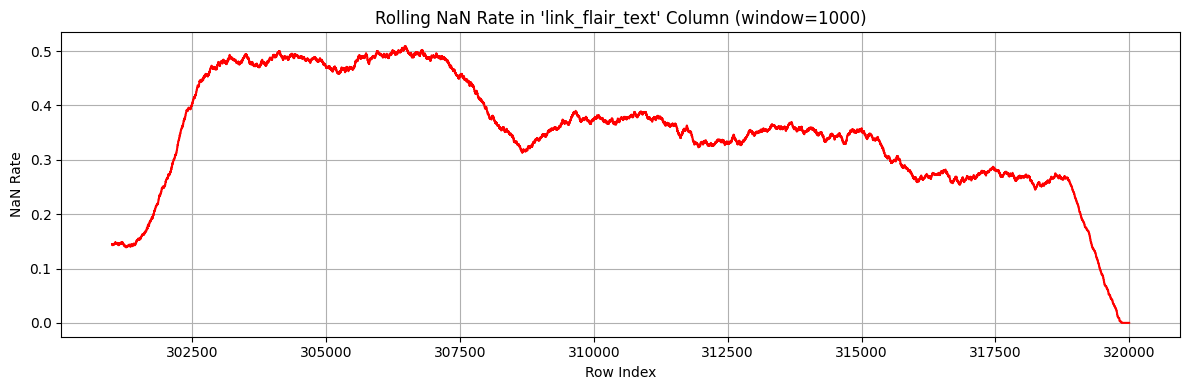

In [55]:
# однако есть очень интересный пик около 300000
nan_roll_avg(df[300000:320000], 'link_flair_text')

In [90]:
# исследуем случайные посты из этого пика
df[300000:301000][df[300000:301000]['link_flair_text'].isna()].sample(10)[['title', 'author', 'selftext']]

,title,author,selftext
300210,[deleted by user],[deleted],[removed]
300948,[deleted by user],[deleted],[removed]
300424,[deleted by user],[deleted],[removed]
300321,[deleted by user],[deleted],[removed]
300989,[deleted by user],[deleted],[removed]
300231,[deleted by user],[deleted],[removed]
300045,[deleted by user],[deleted],[removed]
300245,[deleted by user],[deleted],[removed]
300107,[deleted by user],[deleted],[removed]
300114,[deleted by user],[deleted],[removed]


очень интересно, почему-то почти все посты этого промежутка "удалены" \
Это промежуток 2021 - начало 2022 года, возможно какие-то проблемы с инфраструктурой были, непонятно.

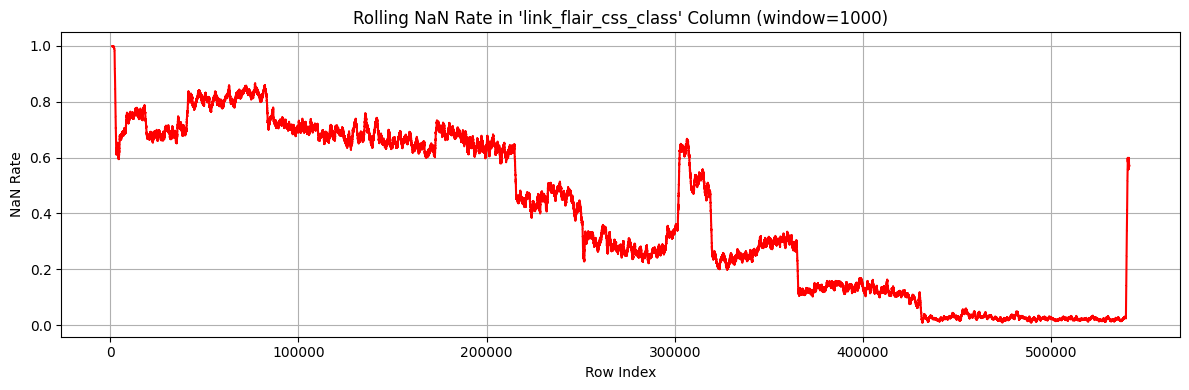

In [115]:
nan_roll_avg(df, 'link_flair_css_class')

Гораздо больше NaN, но это вспомогательная фича, она просто аггрегирует предыдущую в более удобные категории. \
Так что её можно восстановить по предыдущей, где возможно.

Также она будто-бы редко парсится напрямую, судя по скачку NaN-ов в конце, в API-части:

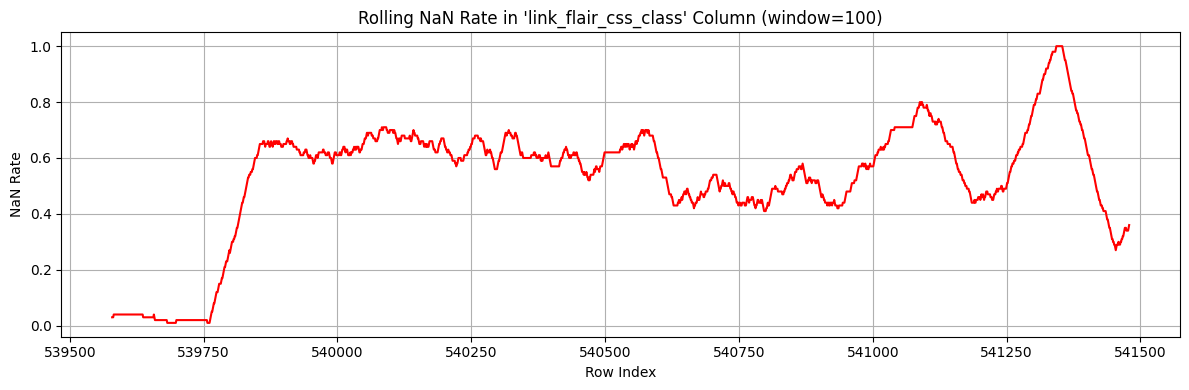

In [114]:
nan_roll_avg(df.tail(2000), 'link_flair_css_class', 100)

In [116]:
# давайте отсортируем API-часть по времени создания, как и архивную часть
df = df.sort_values(by='created_utc').reset_index(drop=True)

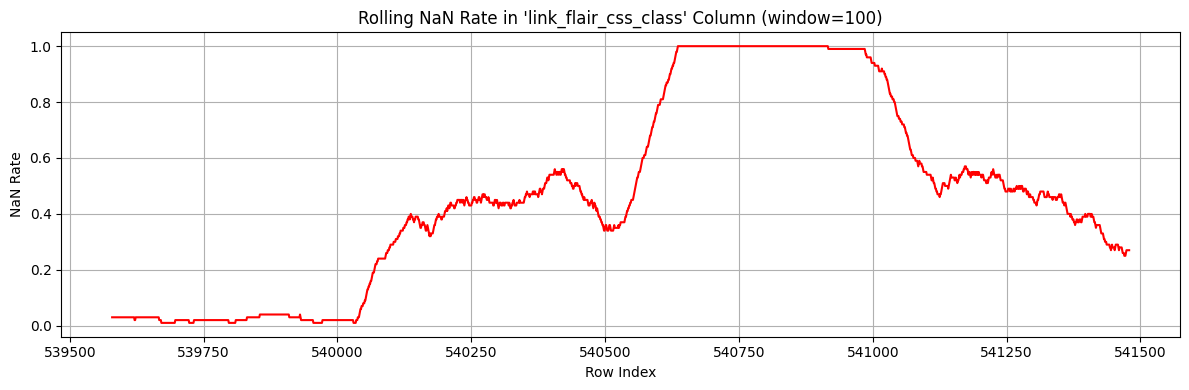

In [119]:
nan_roll_avg(df.tail(2000), 'link_flair_css_class', 100)

Интересно, странный пик вокруг 540750 \
Это пару недель назад

### url
---
напоминаю, это ссылка на вложение поста \
Может быть картинкой в домене реддита, может быть ссылкой на картинку где-то ещё. \
Не очень важная фича, т.к. эти ссылки можно извлечь вручную из `selftext`, - но может быть полезна.

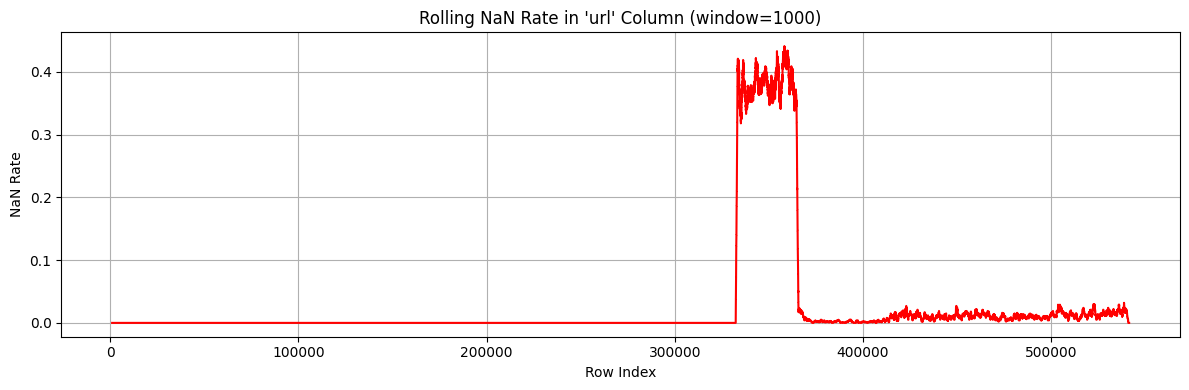

In [124]:
nan_roll_avg(df, 'url')

Интересная концентрация NaN вокруг 350000

In [141]:
# исследуем случайные посты из этого пика
df[340000:360000][df[340000:360000]['url'].isna()].sample(10)[['title', 'author', 'selftext']]

,title,author,selftext
350732,"please, please. my moustache eating the causal...",[deleted],[removed]
359414,Grandpa has cancer and it isn’t looking good. ...,[deleted],[removed]
348821,please someone remove the text and the song st...,[deleted],[deleted]
342113,Could someone enhance/unblur this picture of m...,[deleted],[deleted]
342268,Please remove the silly text I used on my stor...,[deleted],[deleted]
345008,Can someone remove the person on the left? I w...,[deleted],[deleted]
355314,Remove background people and van. Align pictur...,[deleted],[deleted]
340846,[SPECIFIC] Can someone please remove the hangi...,[deleted],[deleted]
343877,Can anyone help remove the wrinkles from the s...,[deleted],[deleted]
355713,Low Res to High Res- Willing to pay- Looking t...,[deleted],[removed]


Это в около апреля 2023, причину такой "чистки" опять не могу понять.

### author
---
юзернейм автора, можно, например, искать частых клиентов и отслеживать их работы \
(или, наоборот, чистить все посты сомнительных личностей)

In [147]:
df['author'].value_counts()

author
[deleted]              137372
RealJohnGillman           244
Randomreddituser1o1       173
Physical-Egg-666          170
CoolClark                 132
                        ...  
emmaw000                    1
falseinfinity               1
PapaStalin1944              1
givemesucccc                1
boyyhowdy                   1
Name: count, Length: 253114, dtype: int64

Очень много [deleted] авторов:

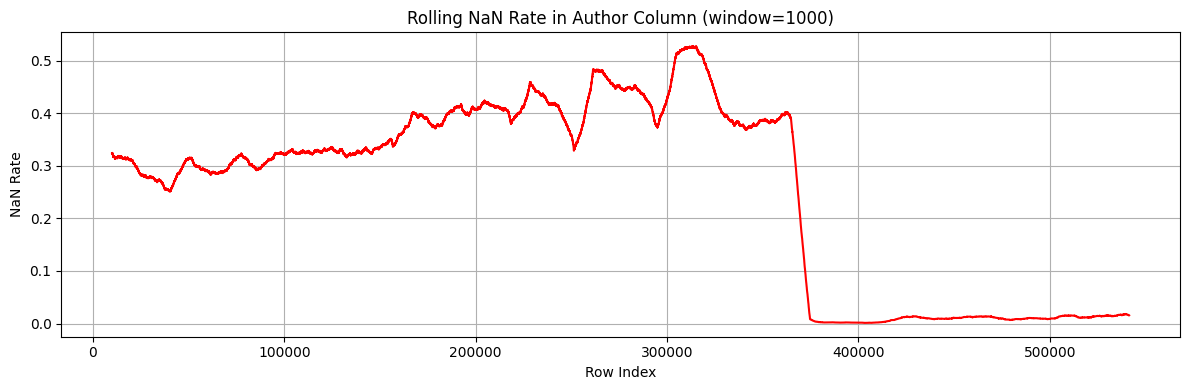

In [153]:
nan_mask = (df['author'] == '[deleted]').astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red')
plt.title(f"Rolling NaN Rate in Author Column (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.tight_layout()
plt.show()

Много старых аккаунтов покинули реддит, пару лет назад тенденция исчезла

In [154]:
# реальные NaN
df[df['author'].isna()]

,link_flair_text,url,link_flair_css_class,id,created_utc,title,author,selftext,domain,num_comments,ups,score,is_reddit_media_domain,total_awards_received,upvote_ratio,src
453659,Free :snoo:,https://www.reddit.com/gallery/1dc0nhk,free,1dc0nhk,1.717958e+09,Can somebody remove my bra please LOL? Engagem...,NaN,I didn’t realize it revealed my bra so much un...,reddit.com,997,13873.0,13873,0.0,0.0,0.88,api
479671,Paid :redditgold:,https://www.reddit.com/gallery/1eohb1v,paid,1eohb1v,1.723254e+09,Could anyone help me remove my daughter’s elf ...,NaN,she loves these pictures but she had like a da...,reddit.com,41,442.0,442,0.0,0.0,0.93,api
510669,Solved ✅,https://www.reddit.com/gallery/1gbyoax,NaN,1gbyoax,1.729874e+09,Can you replace my buddy’s head with my dogs? ...,NaN,NaN,reddit.com,134,3942.0,3942,0.0,0.0,0.97,api
540065,Solved ✅,https://i.redd.it/oaiei7l799pe1.jpeg,NaN,1jdd4y1,1.742220e+09,Can anyone remove the shoes please?,NaN,"Hi, it’s my boyfriend’s fav photo of his dog b...",i.redd.it,28,63.0,63,1.0,0.0,0.97,api
540092,Free :snoo:,https://i.redd.it/4nxzb6gbbfpe1.jpeg,free,1je1m7u,1.742293e+09,I just met Steve-O! But my hands were shaking....,NaN,NaN,i.redd.it,44,1045.0,1045,1.0,0.0,0.97,api
540288,Free :snoo:,https://www.reddit.com/gallery/1jijo51,free,1jijo51,1.742795e+09,My grandfather passed away and I would like a ...,NaN,"For Anibal\n\nMy grandfather, (one on the far ...",reddit.com,6,15.0,15,0.0,0.0,1.00,api
540314,Free :snoo:,https://www.reddit.com/gallery/1jj9spb,free,1jj9spb,1.742872e+09,Can you please make my pet chicken look like h...,NaN,NaN,reddit.com,10,13.0,13,0.0,0.0,0.93,api
540361,Free :snoo:,https://i.redd.it/25zlwvjfc1re1.jpeg,free,1jkbozk,1.742995e+09,Can anyone edit Mr Aphex Twin’s face onto this...,NaN,"Got no money to tip with though, sorry :/",i.redd.it,2,11.0,11,1.0,0.0,0.82,api
540554,Solved ✅,https://www.reddit.com/gallery/1jouyoz,NaN,1jouyoz,1.743512e+09,April Fools,NaN,Can someone please just put the dog on top of ...,reddit.com,9,8.0,8,0.0,0.0,0.91,api
541179,Paid :redditgold:,https://www.reddit.com/gallery/1jyn6av,paid,1jyn6av,1.744594e+09,Request for business headshot,NaN,"Hi yall, I started a new job and they are aski...",reddit.com,16,7.0,7,0.0,0.0,1.00,api


их всего 10, почти все из API. \
Я полистал некоторые из них, везде автор [deleted]. \
Возможно, это не отразилось в посте. Возможно, я неверно паршу [deleted] авторов.

### title, selftext
---
напоминаю, это заголовок и тело поста - самое важное.

In [159]:
len(df[df['title'].isna()]), len(df[df['selftext'].isna()])

(0, 300600)

Заголовок есть всегда, тело часто оставляют пустым. \
Однако рано говорить, что в заголовках нет пропусков:

In [156]:
df['title'].value_counts().head(5)

title
[deleted by user]            7253
[image processing failed]     918
Help                          217
Request                       190
Photoshop request             187
Name: count, dtype: int64

In [157]:
df['selftext'].value_counts().head(5)

selftext
[deleted]     112298
[removed]      41780
Thank you!       119
\n                80
Thanks!           68
Name: count, dtype: int64

Как видим, и там, и тут есть пропуски-заглушки.

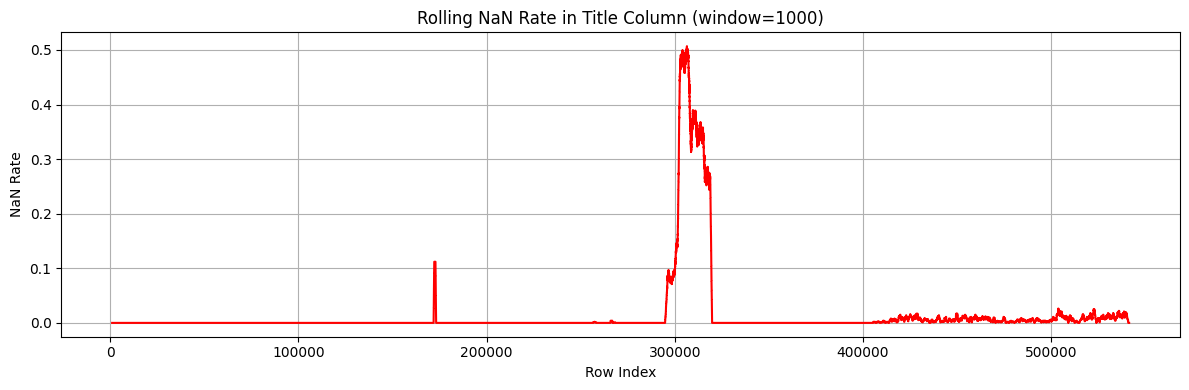

In [160]:
nan_mask = (df['title'].isin(['[deleted by user]', '[image processing failed]'])).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red')
plt.title(f"Rolling NaN Rate in Title Column (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.tight_layout()
plt.show()

Наш любимый странный пик из `flare`-фичей

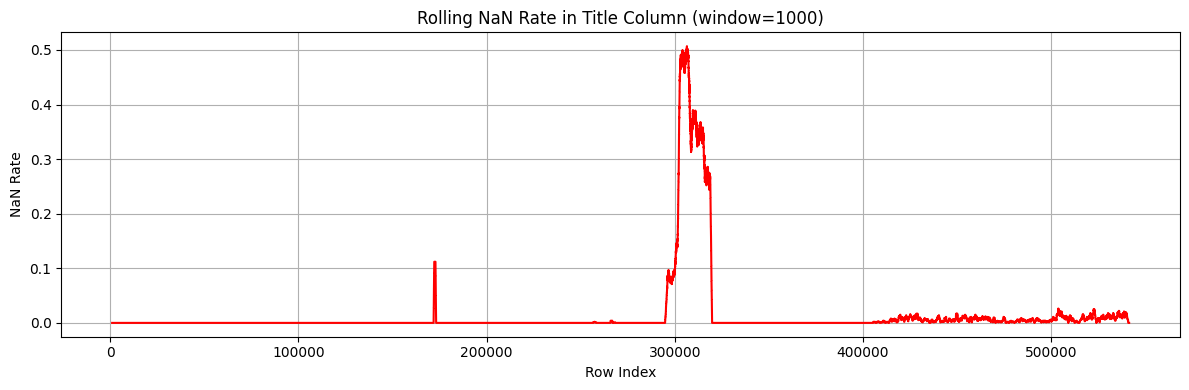

In [161]:
# посмотрим, есть ли у таких "пустых" постов тело?
nan_mask = (df['title'].isin(['[deleted by user]', '[image processing failed]']) & (df['selftext'].isin(['[deleted]', '[removed]']) | df['selftext'].isna())).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red')
plt.title(f"Rolling NaN Rate in Title Column (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.tight_layout()
plt.show()

In [166]:
print(len(df[df['title'].isin(['[deleted by user]', '[image processing failed]']) & (df['selftext'].isin(['[deleted]', '[removed]']) | df['selftext'].isna())]))
print(len(df[df['title'].isin(['[deleted by user]', '[image processing failed]'])]))

8171
8171


Как и ожидалось, у постов с заголовками-заглушками нет тела. \
Скорее всего, у них вообще нет полезных фичей, и такие элементы нужно удалять.

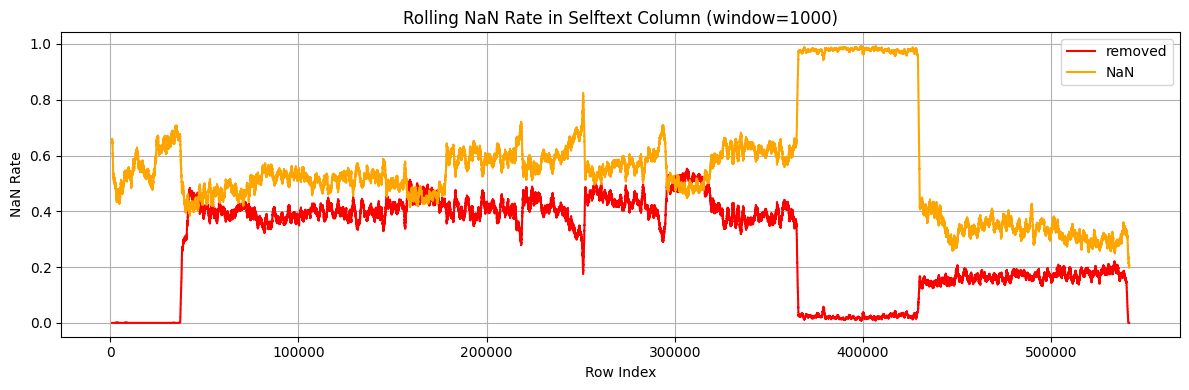

In [168]:
# посмотрим теперь только Selftext
nan_mask = (df['selftext'].isin(['[deleted]', '[removed]'])).astype(int)
nan_mask2 = (df['selftext'].isna()).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
rolling_nan_rate2 = nan_mask2.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red', label='removed')
plt.plot(rolling_nan_rate2, color='orange', label='NaN')
plt.title(f"Rolling NaN Rate in Selftext Column (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Конечно, всегда была и есть большая доля пустых (NaN) Selftext, т.к. часто весь запрос помещается в заголовок и тело пиисать нет смысла. \
Точно также имеет смысл стабильное удаление текста. Это происходит, если человек удаляет пост (например, запрос выполнен). \
Очень интересен провал в removed и рост в NaN вокруг 400000. \
Т.к. они компенсируют друг-друга, скорее всего просто в момент сборки данных в архив все removed были конвертированы в NaN.

### domain, is_reddit_media_domain
---
напоминаю, это где лежит картинка

In [169]:
len(df[df['domain'].isna()]), len(df[df['is_reddit_media_domain'].isna()])

(13991, 128153)

In [173]:
df['domain'].value_counts().head(10)

domain
i.redd.it                344986
self.PhotoshopRequest     79552
imgur.com                 50406
i.imgur.com               23781
i.reddituploads.com        6808
drive.google.com           2237
dropbox.com                1768
m.imgur.com                1451
reddit.com                 1401
ibb.co                      913
Name: count, dtype: int64

In [174]:
df['is_reddit_media_domain'].value_counts()

is_reddit_media_domain
1.0    334489
0.0     78838
Name: count, dtype: int64

заглушек, вроде, нет. \
Вторая фича - вспомогательная вариация первой, её пропуски можно заполнить по первой

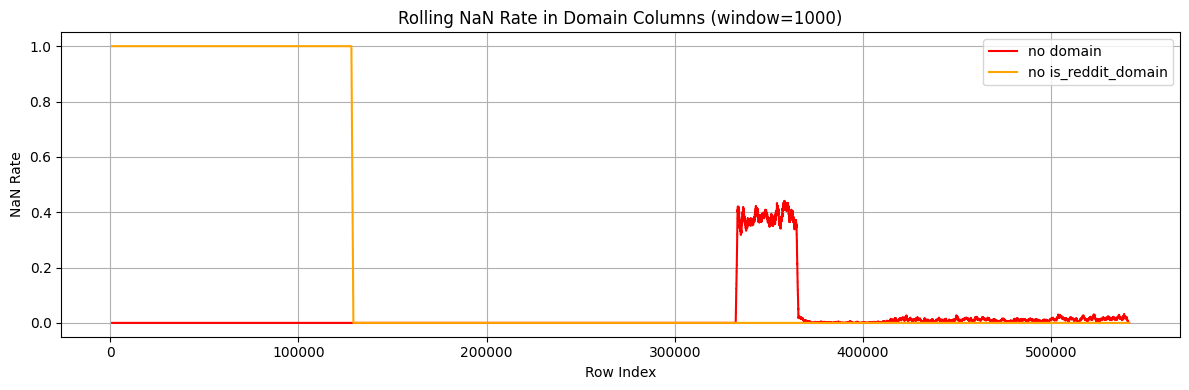

In [186]:
nan_mask = (df['domain'].isna()).astype(int)
nan_mask2 = (df['is_reddit_media_domain'].isna()).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
rolling_nan_rate2 = nan_mask2.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red', label='no domain')
plt.plot(rolling_nan_rate2, color='orange', label='no is_reddit_domain')
plt.title(f"Rolling NaN Rate in Domain Columns (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Хорошие новости: вспомогательная будевая фича просто не собиралась в первые годы, потому там её можно значительно восстановить, если нужно.\

Почему есть пропуски в домене, не знаю. Но, похоже, распределение идентично NaN URL, что очевидно:

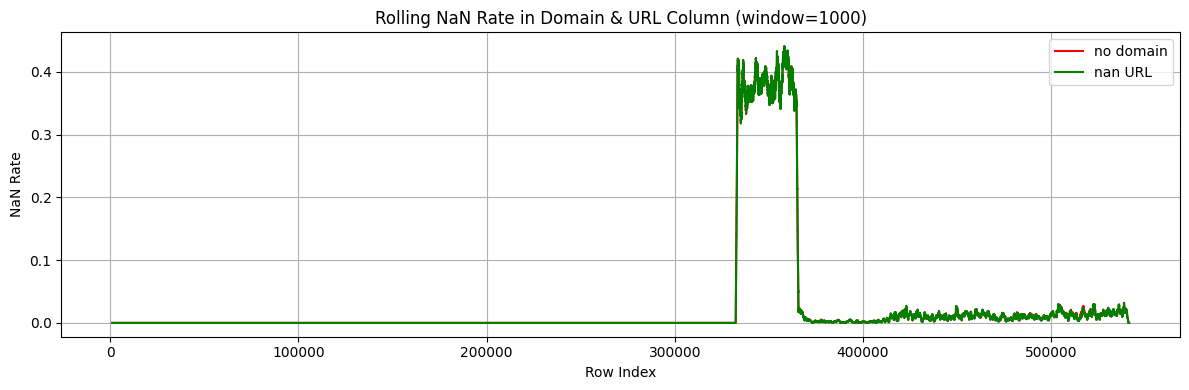

In [187]:
nan_mask = (df['domain'].isna()).astype(int)
nan_mask2 = (df['url'].isna()).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean()
rolling_nan_rate2 = nan_mask2.rolling(window).mean()
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red', label='no domain')
plt.plot(rolling_nan_rate2, color='green', label='nan URL')
plt.title(f"Rolling NaN Rate in Domain & URL Column (window={window})")
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### num_comments, ups, score, total_awards_received, upvote_ratio
---
численные метрики поста, по ним видна популярность и оценка поста

In [189]:
for col in ['num_comments', 'ups', 'score', 'total_awards_received', 'upvote_ratio']:
    print(col)
    print(len(df[df[col].isna()]))
    print(df[col].value_counts().head(5))
    print()

num_comments
0
num_comments
1    133187
0     82180
3     46821
4     42129
2     41831
Name: count, dtype: int64

ups
254229
ups
1.0    207838
2.0     31824
3.0     12662
0.0     12112
4.0      4488
Name: count, dtype: int64

score
0
score
1    366024
2     63803
0     33048
3     26627
4      9682
Name: count, dtype: int64

total_awards_received
196355
total_awards_received
0.0    343803
1.0       944
2.0       198
3.0        65
4.0        35
Name: count, dtype: int64

upvote_ratio
251118
upvote_ratio
1.00    211417
0.50     19407
0.67     10964
0.75      4840
0.67      3332
Name: count, dtype: int64



Сразу можно вспомнить, что `ups` и `score` почти идеально скоррелированы. \
т.е. если в `ups` так много пропусков, а в `score` пропусков 0, то можно смело удалять `ups`

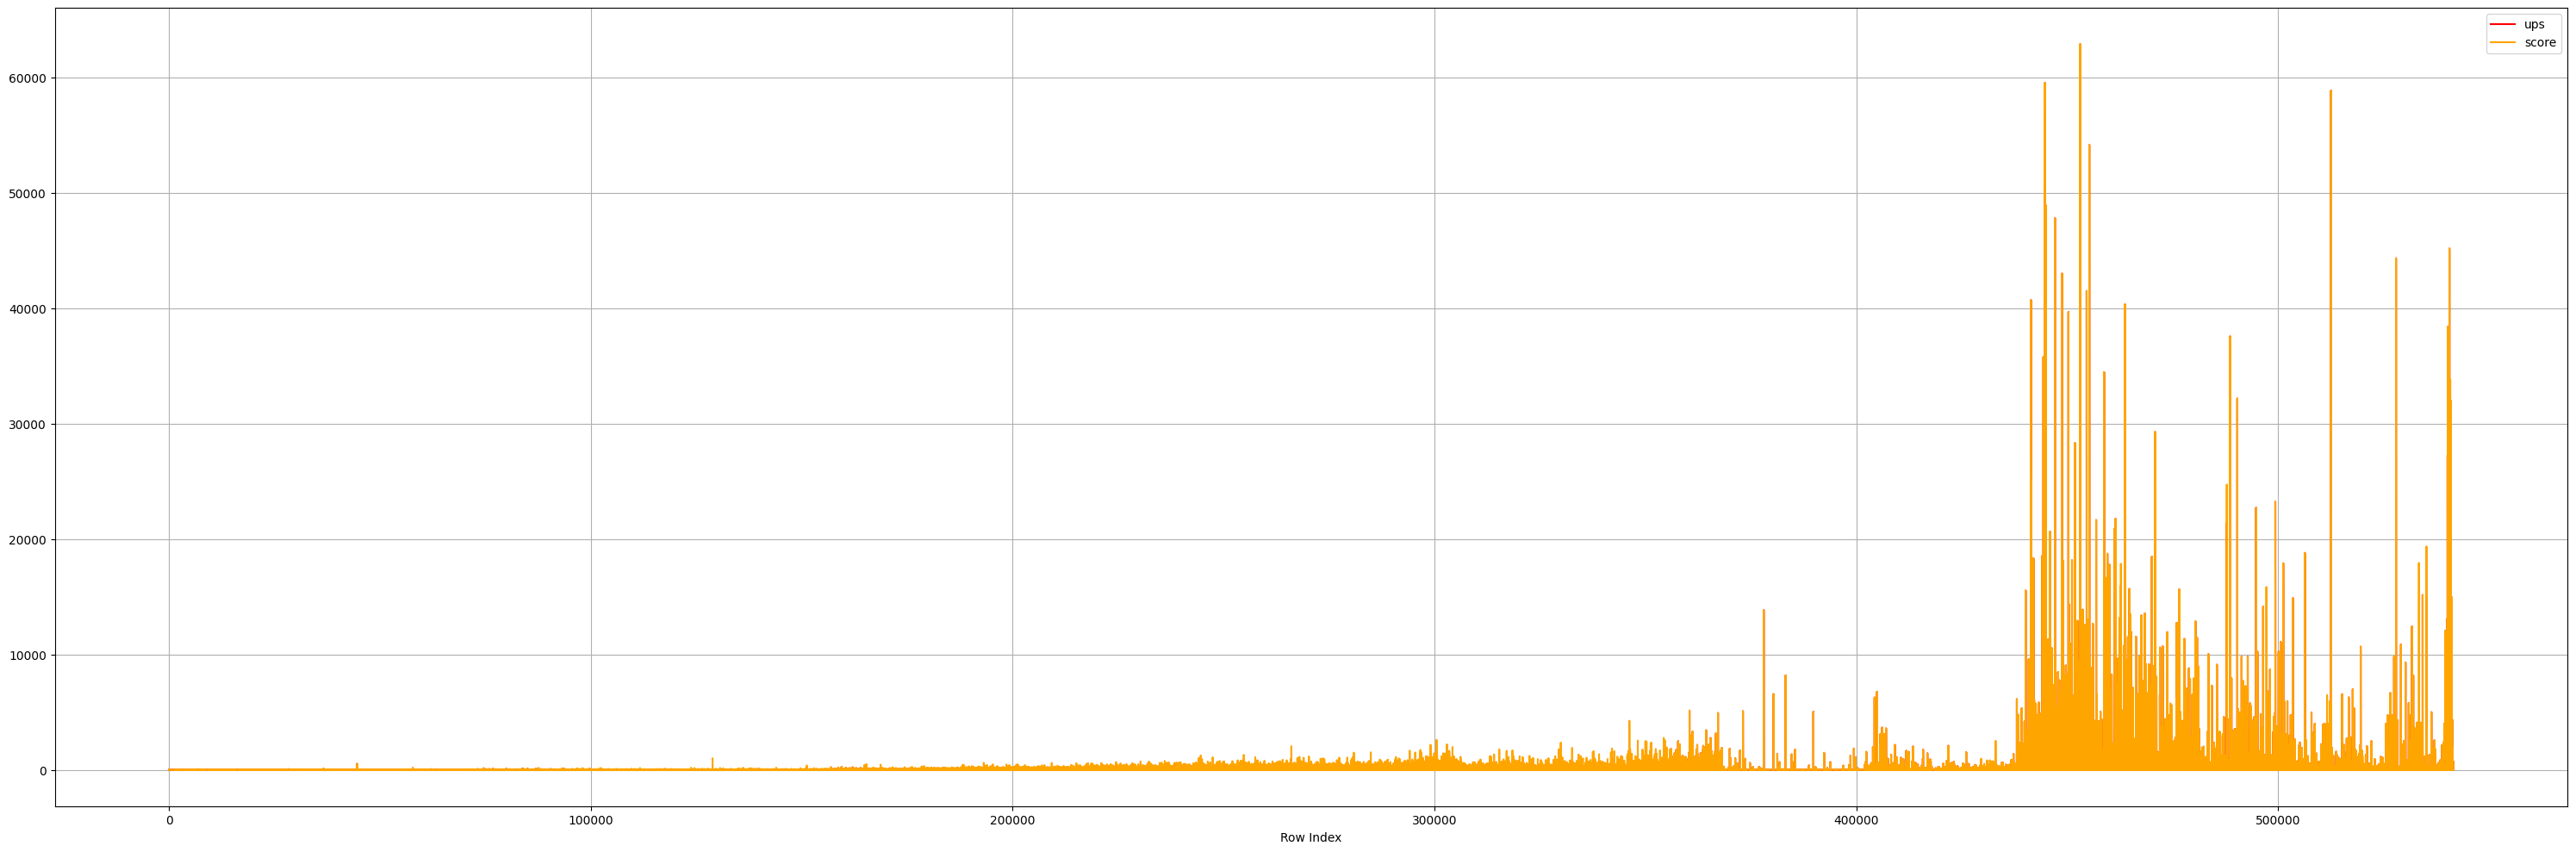

In [193]:
plt.figure(figsize=(30, 10))
plt.plot(df['ups'], color='red', label='ups')
plt.plot(df['score'], color='orange', label='score')
plt.xlabel("Row Index")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [221]:
# интересно, кроме NaN, в скольки местах они отличаются?
df[(~df['ups'].isna()) & (df['ups'] != df['score'])][['ups', 'score']]

,ups,score
423557,3.0,4
423558,23.0,25
423559,4.0,5
423586,38.0,40
423606,31.0,33
...,...,...
539809,20.0,21
539854,1.0,2
539942,1.0,2
539957,25.0,28


Всего в 4879 примерах, и отличия очень слабые. Похоже, можно смело удалять `ups`.

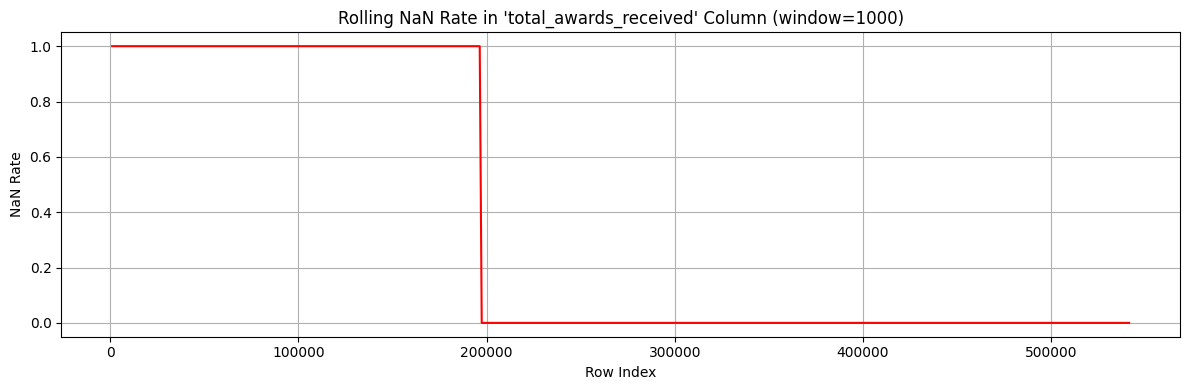

In [231]:
nan_roll_avg(df, 'total_awards_received')

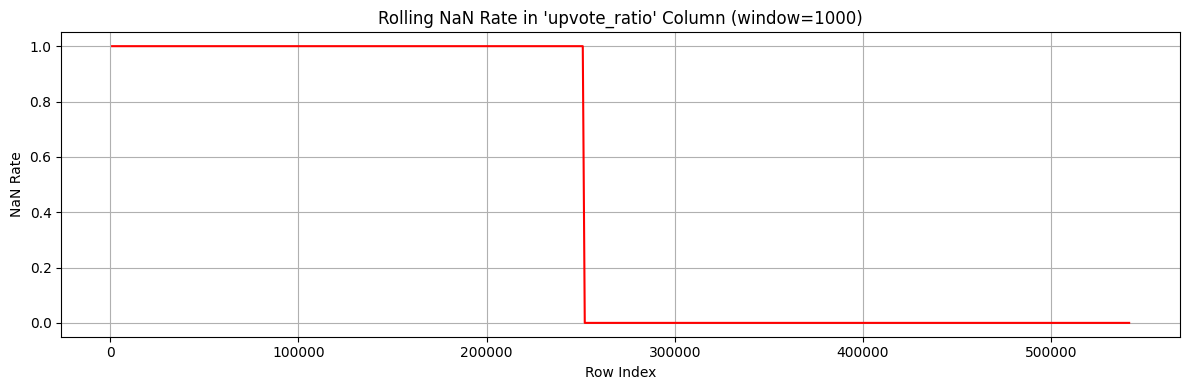

In [230]:
nan_roll_avg(df, 'upvote_ratio')

Отлично, эти две метрики просто не собирались в старые времена, сейчас всё хорошо.

### Выбросы

<Axes: >

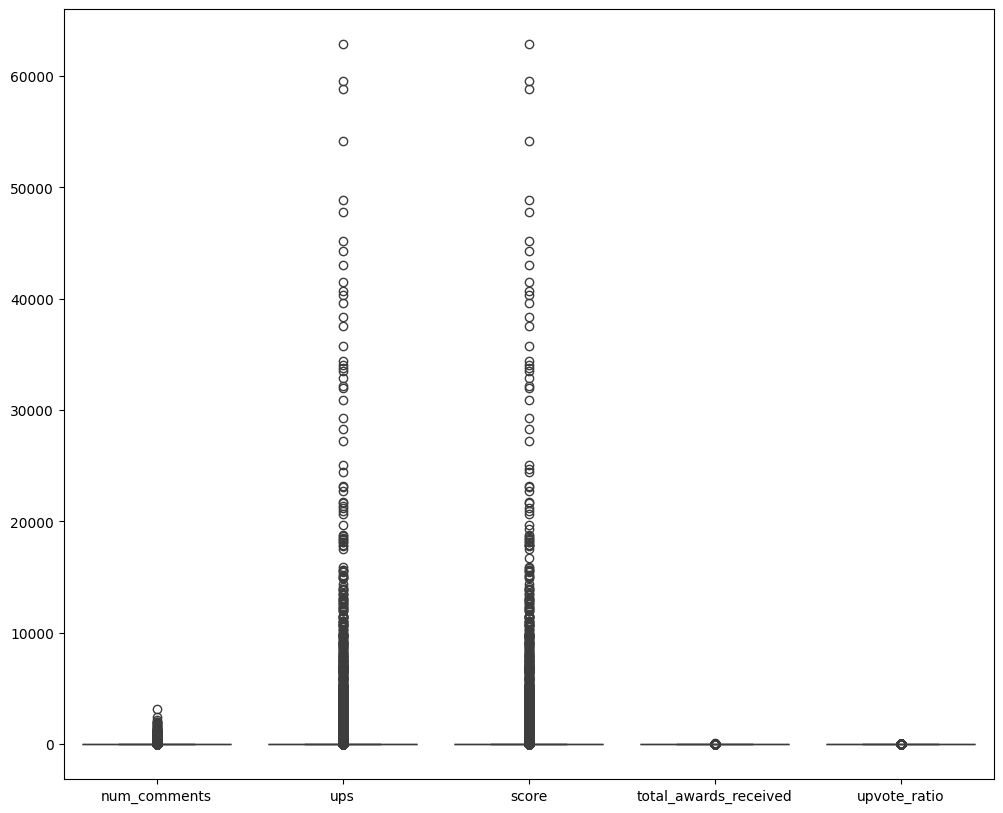

In [239]:
# посмотрим визуально
plt.figure(figsize=(12, 10))
sns.boxplot(df[['num_comments', 'ups', 'score', 'total_awards_received', 'upvote_ratio']])

Видны сильные выбросы в `ups` и `score`, а также в `num_comments`. \
Это нормально, т.к. в соц.сетях обычно очень много максимально непримечательных постов (score и число комментариев около 0),\
а также относительно немного популярных постов (очень много комментариев и очень высокий скор).

Удалять выбросы не нужно. Наоборот, тут их можно, например, пофильтровать в отдельный класс популярных постов.

>Напоминаю, что на нашем датасете мы ничего напрямую обучать не собираемся. Нам нужны лишь списки разнообразных живых вопросов на редактирование (и картинки, их будем парсить позже).

Категориальные признаки мы подробно рпзбирали и в предыдущей HW, и в этой выше. \
Я думаю, некоторые небольшие атипичные категории можно считать выбросами. С ними всеми мы разобрались.

## **Часть 2: «Выбор подходящего оружия»**

- [ ]  Примените несколько разных методов работы с пропусками, выбросами.
- [ ]  Приведите данные в единый вид, поработайте над категориальными признаками.
- [ ]  Оцените, как каждый из методов повлиял на распределение данных и результаты простого анализа (например, расчёт среднего или простая регрессия).

---

Как я уже писал выше, категориальные выбросы уже, считай, обработаны. Численные выбросы нам не мешают и удалять их не стоит. \
Поэтому считаю, что этот раздел нужно целиком посвятить заполнению/удалению пропусков и заглушек различными методами.

In [240]:
# для замеров изменений распределений / метрик
df_old = df.copy(deep=True)

In [242]:
# первым делом удалим полностью бесполезные ряды
# это облегчит дальнейший анализ
bad_text = df[df['title'].isin(['[deleted by user]', '[image processing failed]']) & (df['selftext'].isin(['[deleted]', '[removed]']) | df['selftext'].isna())]
bad_text

,link_flair_text,url,link_flair_css_class,id,created_utc,title,author,selftext,domain,num_comments,ups,score,is_reddit_media_domain,total_awards_received,upvote_ratio,src
171839,UNSOLVED,https://i.redd.it/8gejebrejkd11.jpg,unsolved,93uar1,1.533167e+09,[deleted by user],australian_babe,NaN,i.redd.it,1,NaN,1,1.0,NaN,NaN,archive
171842,NaN,https://i.redd.it/0vqvdc25okd11.jpg,NaN,93uhou,1.533169e+09,[deleted by user],[deleted],[deleted],i.redd.it,0,NaN,1,1.0,NaN,NaN,archive
171851,NaN,https://i.redd.it/eoh4ihsa1ld11.jpg,NaN,93v0ja,1.533173e+09,[deleted by user],[deleted],[deleted],i.redd.it,1,NaN,1,1.0,NaN,NaN,archive
171852,NaN,https://www.reddit.com/r/PhotoshopRequest/comm...,NaN,93v2l6,1.533174e+09,[deleted by user],RikkiMarieE,[removed],self.PhotoshopRequest,0,NaN,1,0.0,NaN,NaN,archive
171853,NaN,https://www.reddit.com/r/PhotoshopRequest/comm...,NaN,93v2v6,1.533174e+09,[deleted by user],shotgunparade69,[removed],self.PhotoshopRequest,1,NaN,1,0.0,NaN,NaN,archive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539922,Paid :redditgold:,NaN,paid,1hqkqzi,1.735670e+09,[image processing failed],[deleted],[deleted],NaN,0,1.0,1,1.0,0.0,1.0,archive
539929,Paid :redditgold:,NaN,paid,1hqlaie,1.735671e+09,[image processing failed],[deleted],[deleted],NaN,0,1.0,1,1.0,0.0,1.0,archive
539967,Paid :redditgold:,NaN,paid,1hqnw8w,1.735679e+09,[image processing failed],[deleted],[deleted],NaN,0,1.0,1,1.0,0.0,1.0,archive
539970,Paid :redditgold:,NaN,paid,1hqo13n,1.735679e+09,[image processing failed],[deleted],[deleted],NaN,0,1.0,1,1.0,0.0,1.0,archive


In [243]:
df.drop(index=bad_text.index, inplace=True)

In [252]:
df['title'].value_counts().head(5)

title
Help                 217
Request              190
Photoshop request    187
Please help          146
[Specific]           107
Name: count, dtype: int64

Отлично, заголовков-заглушек не осталось. \
Однако самые частые заголовки - это абстрактные призывы о помощи. \
Они имеют смысл только сконкатенированные с телом запроса. А если тела запроса нет?

In [251]:
# какие бывают заголовки у бессмысленных тел?
bad_text = df[(df['selftext'].isin(['[deleted]', '[removed]']) | df['selftext'].isna())]
bad_text['title'].value_counts().head(30)

title
Photoshop request                                                                                                                                  113
Help                                                                                                                                               110
[Specific]                                                                                                                                          85
Please help                                                                                                                                         77
Photoshop Request                                                                                                                                   63
Request                                                                                                                                             62
Could someone photoshop the parent advisory sticker out of this album cover?            

У удалённых/NaN тел бывают бессмысленные заголовки. \
Все мы не скосим, но можно удалить самые частые

In [253]:
list(bad_text['title'].value_counts().head(30).index)

['Photoshop request',
 'Help',
 '[Specific]',
 'Please help',
 'Photoshop Request',
 'Request',
 'Could someone photoshop the parent advisory sticker out of this album cover?',
 'Photoshop',
 'Help!',
 'Photoshop help',
 'Can anyone remove the text please?',
 'Help please',
 'Photoshop request ',
 'Please help!',
 'Could someone photoshop the parental advisory sticker out of this album cover?',
 'test',
 'Can someone please remove the people in the background?',
 '[SPECIFIC]',
 'Do your worst',
 'Can someone remove the people in the background?',
 'Test',
 'Professional Headshot',
 'Need help',
 'Remove the text please',
 'Specific',
 'Can someone make the background transparent?',
 'Can someone remove the text?',
 'Request to please remove the 3 people in the background of my Fiancé and I',
 'I am trying to put this on a 24x36 poster but it comes out very blurry. Is there anyway someone can make this less blurry and pixelated? Thanks',
 '[SPECIFIC] Can anyone increase the resolution o

In [255]:
bad_both = bad_text[bad_text['title'].isin(
    ['Photoshop request',
     'Help',
     '[Specific]',
     'Please help',
     'Photoshop Request',
     'Request',
     'Photoshop',
     'Help!',
     'Photoshop help',
     'Help please',
     'Photoshop request ',
     'Please help!',
     'test',
     '[SPECIFIC]',
     'Test',
     'Need help',
     'Specific'
    ]
)]

df.drop(index=bad_both.index, inplace=True)

Отлично, теперь заполним пропуски и заглушки в текстах осмысленных примеров.

Проблема в том, что заполнять пропуски в `selftext` нечем. \
Единственное - можно скопировать `title`, но зачем?

Предлагаю вместо прямого заполнения `title` и `selftext` создать третий признак `fulltext` и заполнить его конкатенацией первых двух:
1. если в `selftext` заглушка, заполняем только значением `title`
2. иначе заполняем конкатенацией `title` и `selftext` через точку с запятой и пробел

Так мы сохраним отдельно тело и заголовок (на всякий случай), и получим важный заполненный признак, который потом можно будет экспортировать для основной задачи.

In [293]:
def get_fulltext(row):
    if row['selftext'] in ['[deleted]', '[removed]', np.nan]:
        return row['title']
    else:
        return row['title'] + '; ' + row['selftext']

df['fulltext'] = df.apply(get_fulltext, axis=1)

In [309]:
list(df['fulltext'].sample(5))

['LinkedIn Photo Request',
 'Would anyone be able to photoshop the lady out of this picture? Please!🫶🏼; I’ll tip $5! Thank you!!!',
 '[Specific]Can anyone cut out this text?',
 '[SPECIFIC] Can someone please make the white background transparent?',
 'Can someone please remove this "pair shaped loser" from my family vacay pic?']

Вроде, сработало хорошо.

Новая фича `fulltext` также позволяет сделать ещё одну фичу - длину текста!

In [313]:
df['text_len'] = df['fulltext'].str.len()

<Axes: >

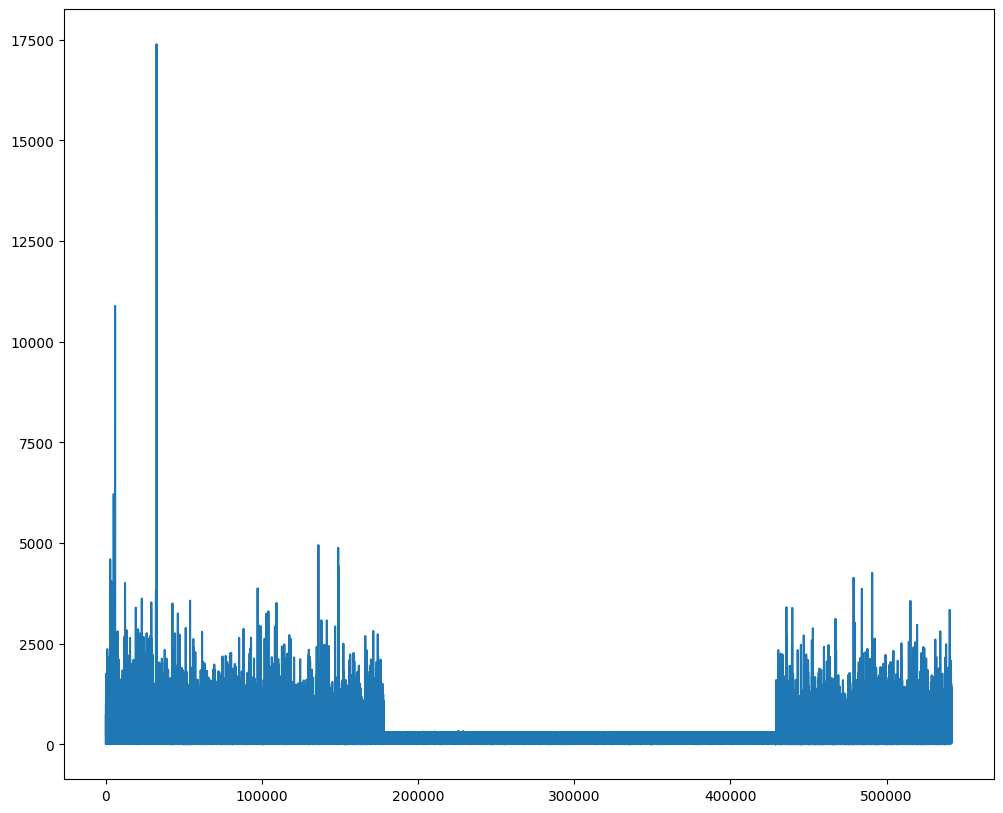

In [318]:
plt.figure(figsize=(12, 10))
df['text_len'].plot()

Интересный провал, наверное он связан с невалидными `Selftext`:

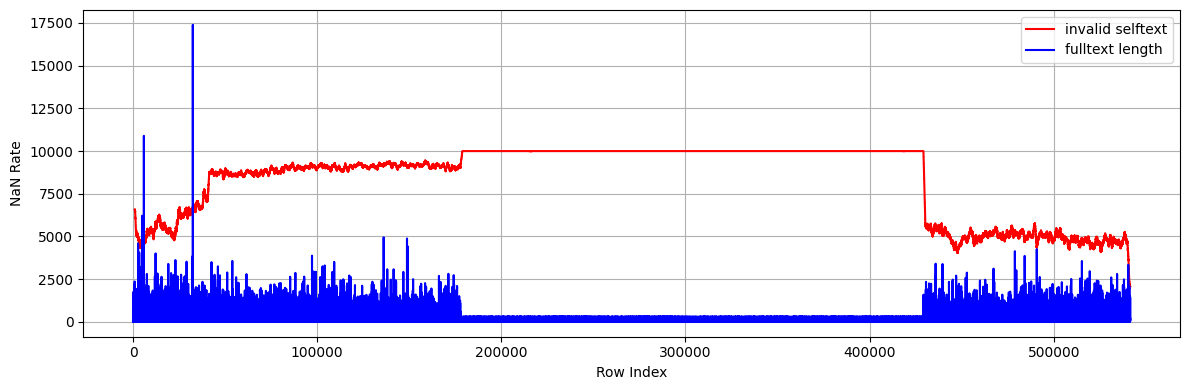

In [340]:
# посмотрим плотность невалидных Selftext на этом же графике
# (умножили nan_rate на 10000 для общего масштаба)

nan_mask = ((df['selftext'].isin(['[deleted]', '[removed]'])) | (df['selftext'].isna())).astype(int)
rolling_nan_rate = nan_mask.rolling(window).mean() * 10000
window=1000
plt.figure(figsize=(12, 4))
plt.plot(rolling_nan_rate, color='red', label='invalid selftext')
plt.plot(df['text_len'], color='blue', label='fulltext length')
plt.xlabel("Row Index")
plt.ylabel("NaN Rate")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Да, провал в длине текстов объясняется тем, что у них были невалидные тела и они не конкатенировались к заголовкам.

### Выбросы в текстах
---

<Axes: xlabel='text_len'>

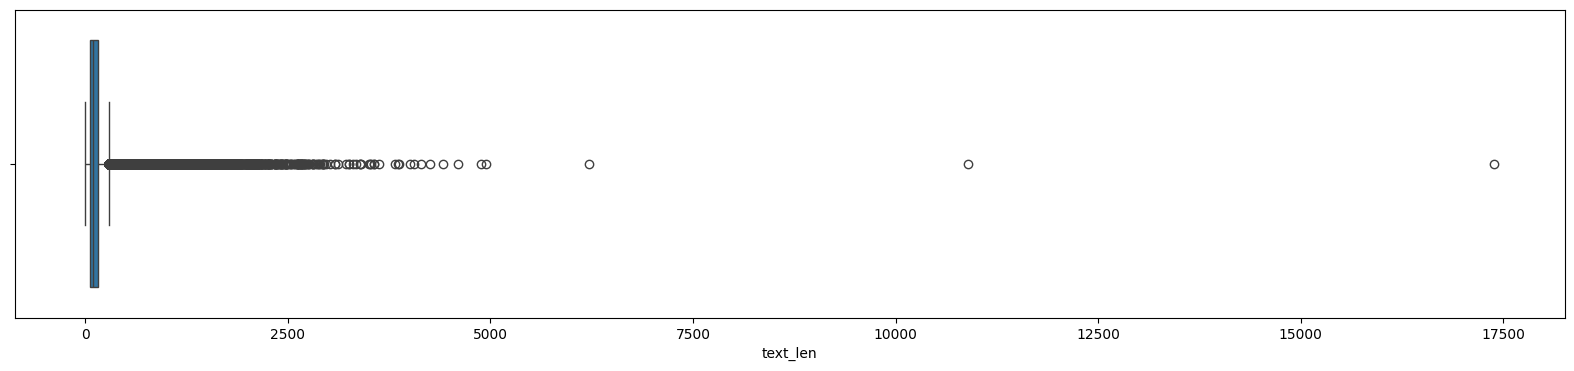

In [5]:
plt.figure(figsize=(20, 4))
sns.boxplot(df['text_len'], orient='h')

Видны сильные выбросы. \
Вот здесь нам неинтересны огромные тексты в тысячи строк, так что выбросы стоит обработать.

In [34]:
# сначала удалим самые большие выбросы, на глаз
# неважно что там, их всего 3
df.drop(index=df[df['text_len'] > 5500].index, inplace=True)

<Axes: xlabel='text_len', ylabel='Count'>

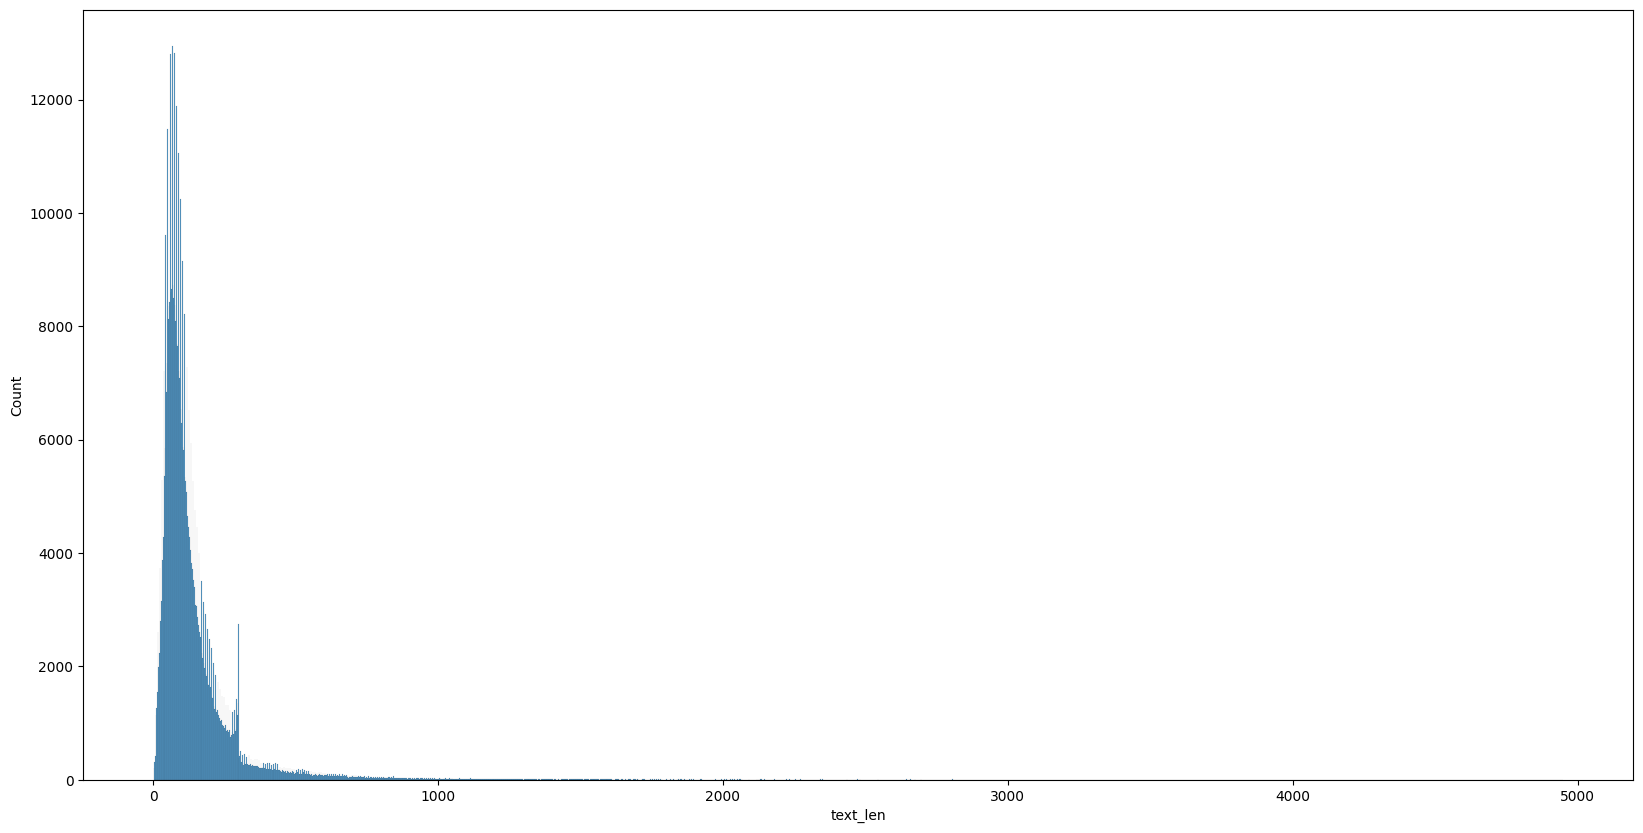

In [36]:
# примерно, как выглядит распределение теперь?
plt.figure(figsize=(20, 10))
sns.histplot(df['text_len'])

Распределение вполне естественное, но выбросы дают большой хвост.

Как можно классифицировать выбросы?

- **Z-score** - будет плохо, т.к. mean и std могут быть смещены из-за сильных выбросов
- **квантильный метод** - можно убрать топ-1% данных, но это, считай, выбор трешхолда вручную
- **интерквартильная эвристика** - ±1.5iqr от медианы - простой и устойчивый метод
- **сложные статистические тесты** - будто бы здесь излишни

In [38]:
# но для начала посмотрим, почему тексты такие длинные
list(df[df['text_len'] >= 4500]['fulltext'])

["It's the Birthday of League of Legends Player Bjergsen, Help Transform him Into Ron Bjergendy; Legendary Shopbeasts of Reddit, lend me your mice.  With luck, a shope of this magnitude, pop pop, may yet appear in the legendary codice of the Google, to be forever a dumbass thing we do.  Godspeed.\n\nPick some of these images that kinda go together and make Bjergsen look like Burgundy in the suit.  Alternatively, you can put Will Ferrell's head on Bjergsen's body, that might be hilarious.\n\nThese [1](http://hydra-media.cursecdn.com/lol.gamepedia.com/8/84/Tsm_bjergsen.png) [2](http://guestofaguest.com/wp-content/uploads/2013/06/r.jpg) kinda go together.  Use your imaginginas.\n\n\nHere's some different source images for Bjergsen(Søren Bjerg).\n[1](http://dandinh.com/wp-content/uploads/2013/12/Bjergsen-%E2%80%93-Fitting-in-with-TSM-560x315.jpg)\n[2](http://i.imgur.com/t0CVtlj.png)\n[3](http://st.elohell.net/public/chill/a3000192c36b7fa2696c31b9c6fd11ac.png)\n[4](http://pthumbnails.5min.c

ОК, на то есть две причины:
1. очень длинный, специфичный запрос-история - нам такие не нужны, особенно если их немного
2. крупную часть запроса занимают длинные ссылки на изображения

Сначала нужно разобраться со второй причиной. \
Хорошей идеей будет почистить все тексты от ссылок, заменив их плейсхолдерами типа `URL_PLACE`. \
Если URL-ы понадобятся, их можно будет восстановить из `selftext`.

In [97]:
def clean_urls(text):
    # заменяем markdown-вставки URL-ов
    text = re.sub(r'\[([^\]]+)\]\(https?://[^\s\n]+', r'[\1](URL_PLACE)', text)
    
    # заменяем простые вставки URL-ов
    text = re.sub(r'https?://[^\s\n]+', 'URL_PLACE', text)
    
    return text

df['fulltext'] = df['fulltext'].apply(clean_urls)

In [128]:
list(df.sample(5)['fulltext'])

['Backround color change - rather trivial for you I suppose; URL_PLACE\n\nId love to have it with a dark background to fit my desktop:\n\nURL_PLACE\n\nThanks in advance',
 "[Specific] Hi guys! I'm a long time lurker. I'm an engineer and got laid off and I'm trying to get a new job. I was wondering if someone could help me by editing out the background so that it's just white for my LinkedIn profile. I would really appreciate it. Thanks so much!",
 '[Specific] So I took this photo of my stepdad but unfortunately one of the light balls behind him created this weird distorted aurora around his head. If anyone can take it out that would be great thank you!',
 'Can you change the background to make it look less edited?',
 'Request: different background including the kids, not the trash road. Best gets $20 ']

Отлично, в первом сэмпле заменило всё хорошо, не поудаляв текст вокруг

<Axes: xlabel='text_len'>

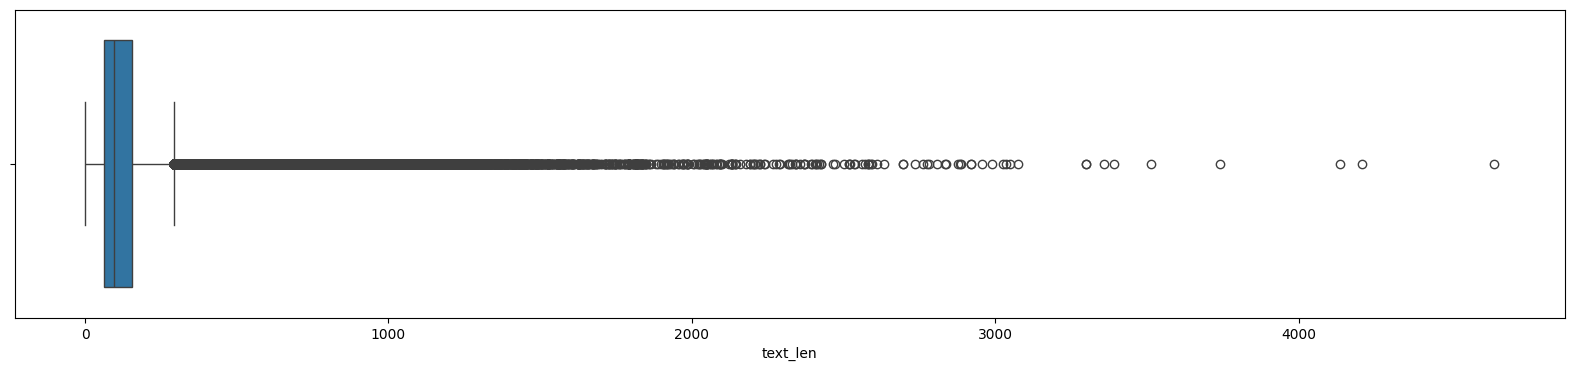

In [131]:
# пересчитываем text_len
df['text_len'] = df['fulltext'].str.len()

# смотрим выбросы теперь
plt.figure(figsize=(20, 4))
sns.boxplot(df['text_len'], orient='h')

In [133]:
# как теперь выглядят длинные тексты?
list(df[df['text_len'] > 1000].sample(3)['fulltext'])

['[Specific] Can somone replicate this gradient effect and "sunburst" lines? (or teach me the name of this "effect" so I can learn how to do it?; I\'m talking about this Image: \n\n[Everything Everything\'s "To the Blade" album cover](URL_PLACE)\n\nWhat I wanted to do was to "separate" the background and guy on the front.\n\nI already cropped the guy to PNG from the 1400x1400 source with some black borders (the Stroke option when blending I believe I used).\n\nI also "kinda" got the gradient right (it\'s not spot on but its decent), but I\'m missing that weird lines coming from behind the guy. I don\'t know how that effect is called or how to replicate it. All the previous steps I got them from random tutorials on youtube (I installed PS 1 hour ago).\n\nThe idea is to finish with something like [THIS](URL_PLACE) (because that arm on the bottom right is cropped and I can\'t draw that on the PNG with the little I know and the 0 drawing my hands can produce).\n\nIn case any of you can hel

Всё еще много длинных текстов, и они выглядят чрезмерно сложными для нашего датасета.

In [175]:
# классифицируем их разными способами:

# z-score
lim1 = np.abs((df['text_len'] - df['text_len'].mean()) / df['text_len'].std(ddof=0)) > 3
df['out1'] = lim1

# квантильный метод
lim2 = np.logical_or(df['text_len'] < df['text_len'].quantile(0.01), df['text_len'] > df['text_len'].quantile(0.99))
df['out2'] = lim2

# IQR
iqr = df['text_len'].quantile(0.75) - df['text_len'].quantile(0.25)
lim3 = np.logical_or(df['text_len'] < (df['text_len'].quantile(0.25) - 1.5 * iqr),
                     df['text_len'] > (df['text_len'].quantile(0.75) + 1.5 * iqr))
df['out3'] = lim3

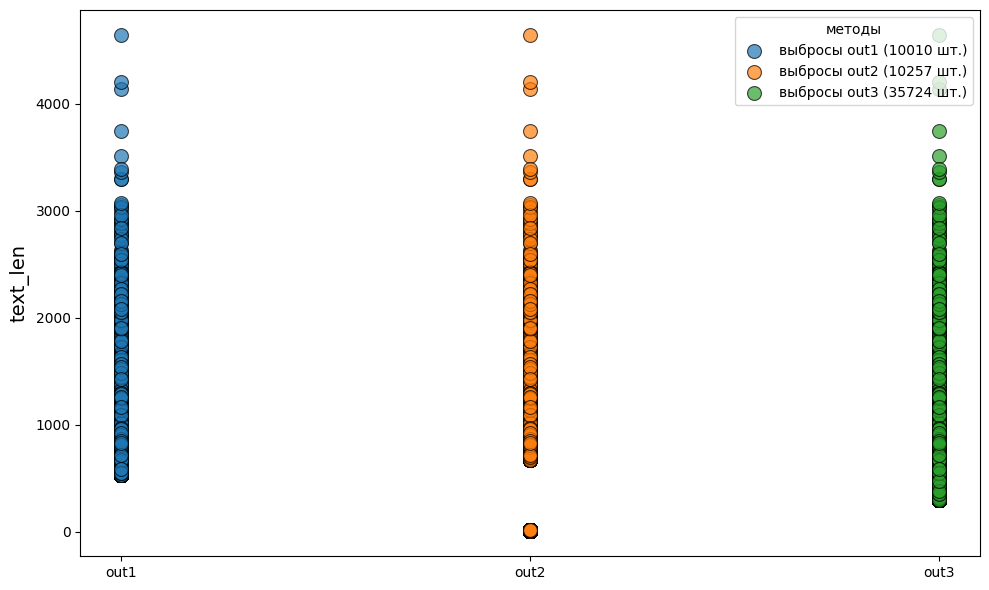

In [176]:

plt.figure(figsize=(10, 6))

# Overlay the points that are outliers, color-coded by method
for method in ['out1', 'out2', 'out3']:
    # Filter the outliers based on each method
    outliers = df[df[method]]
    sns.scatterplot(x=[method] * len(outliers), y=outliers['text_len'], label=f'выбросы {method} ({len(outliers)} шт.)',
                    s=100, edgecolor='black', alpha=0.7, marker='o', legend=False)

plt.ylabel('text_len', fontsize=14)
plt.legend(title="методы", loc='best')

plt.tight_layout()
plt.show()

In [177]:
# то, что удаляет только IQR-метод
list(df[df['out3'] & ~df['out2'] & ~df['out1']].sample(3)['fulltext'])

["Can someone remove the reflection from the door? Will tip; While we enjoy having easy access to the liquor store across the street, we don't want it reflected in the company photo. Still want the information on the door. I can provide another image of the door or what's behind it if needed. Thanks in advance!",
 "Saved a Snap of my niece only after adding text. Could someone please help me remove it? Thanks in advance; So I was trying to take a snapchat of my niece when she started reaching for my phone. I really liked to picture that came out of it but I only realized after I saved it with Snapchat text already added to it. I don't know if it is (im)possible/easy to remove this type of text but any help would be much appreciated! \n\nPhoto: URL_PLACE",
 "PS request these wheels on my truck; This Ford Explorer has the same style wheels I've been thinking about getting for my Ford Ranger. I only have 1 image of the Explorer, but have a few Ranger pics, just not the exact angle. Thanks

In [183]:
# то, что удаляет только квантильный метод снизу
list(df[df['out2'] & (df['text_len'] < 250)].sample(10)['fulltext'])

['Clean up',
 'Hmm',
 'Priorities',
 'Whoops!!',
 'Logo',
 'Background',
 'URL_PLACE',
 'enhance',
 'photoshop 1',
 'Do your best!']

Кажется, IQR-метод захватывает неплохие тексты, \ 
второй метод же удаляет ещё и супер-короткие бессмысленные тексты.

Используем второй метод.

In [188]:
df.drop(index=df[df['out2']].index, inplace=True)
df.drop(columns=['out1', 'out2', 'out3'], inplace=True)

<Axes: xlabel='text_len', ylabel='Count'>

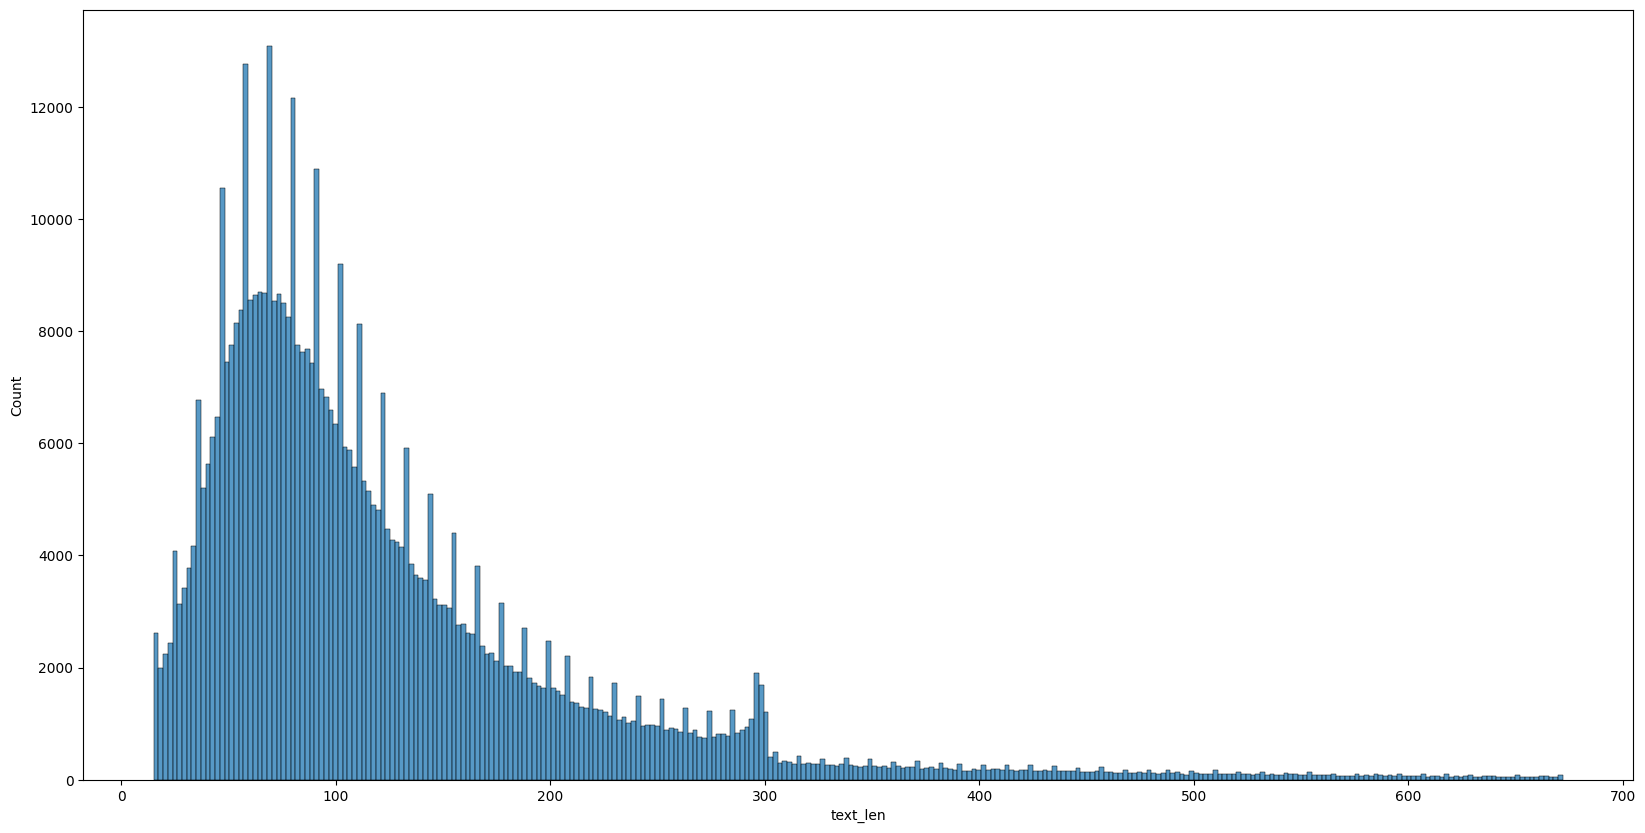

In [186]:
plt.figure(figsize=(20, 10))
sns.histplot(df['text_len'])

Отлично, так и оставим

### author
---
заполним NaN-ы [deleted], как и решили

In [192]:
df['author'].fillna('[deleted]', inplace=True)

/var/folders/p_/mk0v57f13s7dcq7xcryjqlh0s_k83c/T/ipykernel_2668/3847773099.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['author'].fillna('[deleted]', inplace=True)


### url
---
оставим NaN-ы, фича чисто вспомогательная \
может, и не нужна будет

### domain, is_reddit_media_domain
---
1. NaN-ы в domain вряд ли удастся заполнить, да и не сильно нужно
2. is_reddit_media_domain можно заполнить через domain; также не супер-важная фича, может и не пригодиться

In [215]:
def fill_reddit_domain(row):
    if pd.notna(row['is_reddit_media_domain']):
        return row['is_reddit_media_domain']
    elif row['domain'] in [
        'i.redd.it', 'self.PhotoshopRequest', 
        'i.reddituploads.com', 'reddit.com'
    ]:
        return 1
    else:
        return 0

df['is_reddit_media_domain'] = df.apply(fill_reddit_domain, axis=1)

### link_flair_text, link_flair_css_class
---
1. из-за риска вотермарок нам важно найти как можно больше платных постов, даже если небольшая часть бесплатных постов попадёт под раздачу. Поэтому часть пропусков в `link_flair_text` можно заполнить, сканируя тексты на предмет ключевых слов, касающихся оплаты
2. `link_flair_css_class` можно частично заполнить через `link_flair_text`

оставшиеся пропуски никак не заполнить

In [219]:
def fill_flair(row):   
    if pd.notna(row['link_flair_text']):
        return row['link_flair_text']
        
    payment_keywords = {'$', '﹩', '＄', 'tip', 'pay', '€', '￡', '£', 'price', 
                        'usd', 'eur', 'gbp', 'paid', 'euro', 'dollar'}
    cleaned_text = re.sub(r'[^\w\s]', '', row['fulltext'].lower()) 
    
    if any(payword in cleaned_text for payword in payment_keywords):
        return 'Paid :redditgold:'
    else:
        return np.nan

df['link_flair_text'] = df.apply(fill_flair, axis=1)

In [224]:
def fill_flair_class(row):   
    if pd.notna(row['link_flair_css_class']):
        return row['link_flair_css_class']  
    elif row['link_flair_text'] in ['Paid :redditgold:', 'Paid (Solved) :redditgold:']:
        return 'paid'
    elif row['link_flair_text'] in ['Serious :snoo:', 'Serious (Solved) :snoo:']:
        return 'serious'
    elif row['link_flair_text'] in ['Free :snoo:']:
        return 'free'
    elif row['link_flair_text'] in ['SOLVED', 'SOLVED ', 'Solved ✅']:
        return 'solved'
    elif row['link_flair_text'] in ['Funny :snoo_joy:', 'Funny (Solved) :snoo_joy:']:
        return 'funny'
    elif row['link_flair_text'] in ['UNSOLVED']:
        return 'solved'
    else:
        return np.nan

df['link_flair_css_class'] = df.apply(fill_flair_class, axis=1)

### num_comments, ups, score, total_awards_received, upvote_ratio
---
1. `score` почти идеально коррелирует с `ups` и не имеет пропусков, потому `ups` удаляем
2. пропуски в total_awards_received и upvote_ratio никак не заполнить.
3. выбросы мы смотрели ранее, они есть и довольно сильные. Удалять их не нужно, но можно создать отдельную фичу `is_popular` и в ней отметить выбросы 

In [226]:
df.drop(columns='ups', inplace=True)

In [227]:
iqr1 = df['num_comments'].quantile(0.75) - df['num_comments'].quantile(0.25)
iqr2 = df['score'].quantile(0.75) - df['score'].quantile(0.25)
lim = np.logical_and(
    df['num_comments'] > (df['num_comments'].quantile(0.25) + 1.5 * iqr1),
    df['score'] > (df['score'].quantile(0.75) + 1.5 * iqr2)
)
df['is_popular'] = lim

In [228]:
df['is_popular'].value_counts()

is_popular
False    494976
True      27240
Name: count, dtype: int64

In [230]:
# метрики до работы с данными
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541480 entries, 0 to 541479
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   link_flair_text         376389 non-null  object 
 1   url                     527514 non-null  object 
 2   link_flair_css_class    324378 non-null  object 
 3   id                      541480 non-null  object 
 4   created_utc             541480 non-null  float64
 5   title                   541480 non-null  object 
 6   author                  541470 non-null  object 
 7   selftext                240880 non-null  object 
 8   domain                  527489 non-null  object 
 9   num_comments            541480 non-null  int64  
 10  ups                     287251 non-null  float64
 11  score                   541480 non-null  int64  
 12  is_reddit_media_domain  413327 non-null  float64
 13  total_awards_received   345125 non-null  float64
 14  upvote_ratio            2

In [231]:
# метрики до работы с данными
df_old.describe()

,created_utc,num_comments,ups,score,is_reddit_media_domain,total_awards_received,upvote_ratio
count,5.414800e+05,541480.000000,287251.000000,541480.000000,413327.000000,345125.000000,290362.000000
mean,1.599392e+09,5.425188,19.482369,13.537429,0.809260,0.006905,0.907123
std,1.030955e+08,18.523136,514.456528,379.527981,0.392885,0.229745,0.182996
min,1.340080e+09,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.508510e+09,1.000000,1.000000,1.000000,1.000000,0.000000,0.950000
50%,1.602596e+09,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,1.700329e+09,6.000000,1.000000,2.000000,1.000000,0.000000,1.000000
max,1.744700e+09,3196.000000,62867.000000,62867.000000,1.000000,94.000000,1.000000


In [232]:
# метрики после работы с данными
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 522216 entries, 0 to 541479
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   link_flair_text         374755 non-null  object 
 1   url                     509294 non-null  object 
 2   link_flair_css_class    368174 non-null  object 
 3   id                      522216 non-null  object 
 4   created_utc             522216 non-null  float64
 5   title                   522216 non-null  object 
 6   author                  522216 non-null  object 
 7   selftext                223316 non-null  object 
 8   domain                  509270 non-null  object 
 9   num_comments            522216 non-null  float64
 10  score                   522216 non-null  float64
 11  is_reddit_media_domain  522216 non-null  float64
 12  total_awards_received   331438 non-null  float64
 13  upvote_ratio            276902 non-null  float64
 14  src                     5

In [233]:
# метрики после работы с данными
df.describe()

,created_utc,num_comments,score,is_reddit_media_domain,total_awards_received,upvote_ratio,text_len
count,5.222160e+05,522216.000000,522216.000000,522216.000000,331438.000000,276902.000000,522216.000000
mean,1.598949e+09,5.452102,13.590995,0.761530,0.007160,0.906275,124.638667
std,1.030255e+08,18.560549,378.614506,0.426149,0.234218,0.183339,94.988749
min,1.340080e+09,-1.000000,0.000000,0.000000,0.000000,0.000000,15.000000
25%,1.508346e+09,1.000000,1.000000,1.000000,0.000000,0.940000,64.000000
50%,1.599190e+09,3.000000,1.000000,1.000000,0.000000,1.000000,96.000000
75%,1.700074e+09,6.000000,2.000000,1.000000,0.000000,1.000000,153.000000
max,1.744700e+09,3196.000000,62867.000000,1.000000,94.000000,1.000000,672.000000


## **Часть 3: «Раскрытие дела»**

- [ ]  Выберите и обоснуйте самый эффективный метод для вашего набора данных.
- [ ]  Сформулируйте краткую рекомендацию по оптимальному подходу к обработке пропущенных значений в вашем датасете.

1. Для каждого признака выбрал и обосновал
2. Для каждого признака также расписал. Если вкратце, то:

- title и selftext - ключевые признаки, сливаем их в один, обрабатываем, убираем выбросы по длине текста
- мета-признаки держим просто на всякий случай, так что по возможности заполняем пропуски, а из-за оставшихся NaN-ов не переживаем
- численные признаки можно использовать как меру популярности поста, удалил корреляции, определил выбросы по счёту и числу комментариев как популярные посты

## 🏆 **Дополнительные баллы** («Расследование с изюминкой»):

*+3 балла* Предложите собственный метод или комбинацию методов, которые лучше всего подходят именно для вашего случая.

В нескольких фичах разработал относительно уникальные и специфичные методы заполнения пропусков и работы с выбросами -  может, это считается)

## Итого

**Часть 1: «Следствие ведёт детектив»**

- [x]  Взял недо-обработанный датасет из задания №1 [Модуль 1. **Введение в сбор данных**](https://www.notion.so/341985de290d4c1280ba3856ac98925f?pvs=21)
- [x]  Проанализировал пропуски и заглушки: определил их долю и расположение, рассмотрел закономерности и предположил причины, где смог
- [x]  Много где сформулировал гипотезы о возможных причинах появления пропусков.
- [x]  Проанализировал датасет на выбросы: мелкие классы в категориальных фичах и визуально выбросы в boxplot-ах в численных фичах (пока визуально, численно выделю их далее)

---

**Часть 2: «Выбор подходящего оружия»**

- [x]  Применил несколько разных методов работы с пропусками и выбросами.
- [x]  Привёл данные в нужный вид, поработал над всеми признаками, заинжинирил несколько композитных удобных признаков, избавился от ненужных.
- [x]  Оценил влияние на распределение данных по ходу работы, а также по результатам.

---

**Часть 3: «Раскрытие дела»**

- [x]  Выбрал и обосновал самые эффективные методы для каждой фичи.
- [x]  Сформулировал краткую рекомендацию по оптимальному подходу к обработке пропущенных значений, заглушек и выбросов в датасете:


- title и selftext - ключевые признаки, сливаем их в один, обрабатываем, убираем выбросы по длине текста
- мета-признаки держим просто на всякий случай, так что по возможности заполняем пропуски, а из-за оставшихся NaN-ов не переживаем
- численные признаки можно использовать как меру популярности поста, удалил корреляции, определил выбросы по счёту и числу комментариев как популярные посты

🏆 **Дополнительные баллы** («Расследование с изюминкой»):

*+3 балла* В нескольких фичах разработал относительно уникальные и специфичные методы заполнения пропусков и работы с выбросами -  может, это считается)

In [234]:
df.to_csv('posts_clean_fin.csv')